# Thermal Model
-----------------------------------------------------

This Python script implements a **1D Radial-Spiral Thermal Model** for a Li-ion battery, inspired by the work of Gomadam et al. (2003) on **Modeling Heat Conduction in Spiral Geometries**. The model simplifies the 2D energy balance equation to a 1D radial-spiral model using a coordinate transformation technique and is discretised using the **Finite Volume Method (FVM)**.

This model captures both **radial and spiral heat conductions** over a wide range of design parameters, providing a computationally efficient alternative to the full 2D model.
<!-- This is a **half-cell model** that focuses on the **cathode (Li(Ni₀.₄Co₀.₆)O₂)** and introduces improvements by accounting for electrolyte transport and overpotential contributions, extending the realism of the classical SPM. -->

### Key Features:
- Heat conduction in spirally-wound batteries using a **1D radial-spiral model**.
- Incorporates radial and spiral heat conduction components via **effective thermal conductivity calculation**.
- Computationally efficient compared to traditional 2D models.
- Can accurately predict temperature distribution for spirally-wound battery designs.

### Model Purpose:
The 1D Radial-Spiral Model is designed to reduce computation time while maintaining sufficient accuracy for predicting temperature distributions in spirally-wound battery cells. This model can serve as a simplified yet accurate tool for battery thermal management analysis.



## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Thermal model

In [19]:
# Parameters
maxit = 100
e11 = 1e-25
N = 20
h = 10
T0 = 300
Tam = 298
hprim = h * (2 * N + 1) / (2 * N + 2)
ro1 = 1347.33
ro2 = 2328.5
cp1 = 1437.4
cp2 = 1269.21
t = np.arange(57.6, 5760 + 57.6, 57.6)
dt = 57.6
D = 18 * 10 ** -3
mendral = 2 * 10 ** -3
X = (D - mendral) / (2 * (2 * N + 1))
R = 2 * N * X
a = np.pi / X
dr = X
n = 2 * (N + 1)
rin = 2 * X

r = np.arange(X / 2, n * X + X / 2, X)
A1 = N * np.pi * X * (X + R)
A2 = N * np.pi * X * (3 * X + R)
rocp_eff = (ro1 * cp1 * A1 + ro2 * cp2 * A2) / (A1 + A2)
d = rocp_eff / dt

lambda1 = 1.04
lambda2 = 1.58

s = np.zeros(N)

Iteration 1: Residual T = 0.009972140079632178
Iteration 2: Residual T = 0.009972140079451276
Iteration 3: Residual T = 0.009972140079389555
Iteration 4: Residual T = 0.009972140079624232
Iteration 5: Residual T = 0.00997214007947366
Iteration 6: Residual T = 0.009972140079266768
Iteration 7: Residual T = 0.009972140079306272
Iteration 8: Residual T = 0.009972140079280241
Iteration 9: Residual T = 0.009972140079313815
Iteration 10: Residual T = 0.009972140079150696
Iteration 11: Residual T = 0.009972140079173322
Iteration 12: Residual T = 0.009972140079157518
Iteration 13: Residual T = 0.009972140079175571
Iteration 14: Residual T = 0.009972140078932467
Iteration 15: Residual T = 0.009972140078934918
Iteration 16: Residual T = 0.00997214007895695
Iteration 17: Residual T = 0.009972140078903536
Iteration 18: Residual T = 0.009972140078757748
Iteration 19: Residual T = 0.009972140078822658
Iteration 20: Residual T = 0.009972140078641948
Iteration 21: Residual T = 0.009972140078645851
Ite

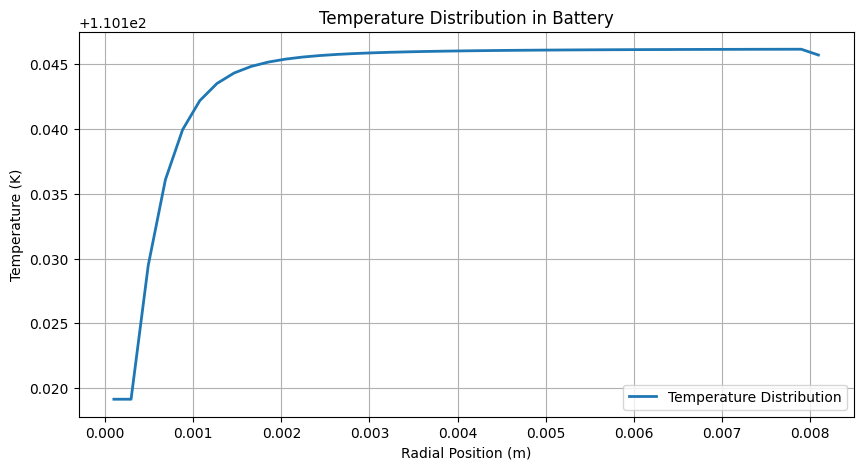

In [20]:
for j in range(N):
    r1A = rin + 2 * X * j
    r1B = r1A + X
    r2A = r1B
    r2B = r1B + X
    s[j] = 1 / lambda1 * np.log(r1B / r1A) + 1 / lambda2 * np.log(r2B / r2A)

lambda_r = np.log10((R + rin) / rin) / np.sum(s)
lambda_eff = np.array([lambda_r + lambda1 / (a ** 2 * r_val ** 2) for r_val in r])

f = lambda_eff / dr ** 2
b = (lambda_eff / r - 2 * lambda1 / (a ** 2 * r ** 3)) / dr

# Initialization
T = np.ones(len(r)) * 300
Told = np.copy(T)
A = np.zeros((n, n))
S = np.zeros(n)

def i_current(t):
    return 12 if t <= 2880 else -12

def qdot(t, r):
    sig1 = 100
    sig2 = 3.8
    sig_eff = (sig1 * X + sig2 * X) / (X + X)
    A2 = N * np.pi * X * (3 * X + R)
    I = i_current(t)
    qd = (1 / sig_eff) * I ** 2 * A2 * r ** 2 / 2
    return qd

# Iterative solver
for k in range(maxit):
    A[0, 0] = 1
    A[0, 1] = -1
    A[-1, -1] = -b[-1] + d + 2 * f[-1]
    A[-1, -2] = b[-1] - f[-1]

    for j in range(1, n - 1):
        A[j, j] = -b[j] + d + 2 * f[j]
        A[j, j + 1] = -d
        A[j, j - 1] = b[j] - f[j]

    for j in range(n):
        S[j] = d * T[j] + qdot(t[j], r[j])

    S[0] = 0
    S[-1] += hprim * Tam

    T_new = np.linalg.solve(A, S)
    alpha = 0.01
    T = alpha * T_new + (1 - alpha) * Told

    # Residual calculation
    residuals = np.abs(T - Told) / Told
    ee1 = np.max(residuals)

    if ee1 < e11:
        break

    Told = np.copy(T)
    print(f'Iteration {k+1}: Residual T = {ee1}')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(r, T, label='Temperature Distribution', linewidth=2)
plt.xlabel('Radial Position (m)')
plt.ylabel('Temperature (K)')
plt.title('Temperature Distribution in Battery')
plt.grid(True)
plt.legend()
plt.show()
